In [ ]:
!pip install setuptools==66
!pip install matplotlib_inline
!pip install d2l==1.0.0b

In [2]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [4]:
#BERT Model
class BiRNN(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
    super(BiRNN, self).__init__()
    #Use glove for embedding
    self.embedding = nn.Embedding(vocab_size, embed_size)
    #Use bidirectional LSTM 
    self.encoder= nn.LSTM(embed_size, num_hiddens, num_layers = num_layers, bidirectional=True)
    #Binary classification. 2 classes. it's input shape is explained in the forward function
    self.decoder = nn.Linear(4 * num_hiddens, 2)

  def forward(self, inputs):
    # inputs shape: (batch_size, # steps)
    # LSTM requires input 1st dimension to be temporal dimension. 
    # --> we transpose before obtaining tokens representation
    # output shape = (# steps, batch_size, word vector dimension)
    embeddings = self.embedding(inputs.T)
    # print('embedding shape before flatten ', embeddings.shape)
    self.encoder.flatten_parameters()
    # print('embedding shape after flatten ', embeddings.shape)
    # returns hidden states of the last hidden layer at different time steps
    # output shape = (# steps, batch_size, 2 * # hidden)
    # NOTE: that encoder returns outputs, and state
    outputs, _ = self.encoder(embeddings)
    # concat hidden states at initial timestep and final timestep 
    # as input of fully connected layer.
    # encoding shape = (batch_size, 4 * hidden_units)
    encoding = torch.cat((outputs[0], outputs[-1]), dim = 1)
    outs = self.decoder(encoding)

    return outs

#Test run 
# We'll use embed size from Glove so 
# change it if you want to use bigger with Glove embeding size
embed_size = 100
num_hiddens = 100
num_layers = 2
devices = d2l.try_all_gpus()

net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [ ]:
def init_weights(module):
  if type(module) == nn.Linear:
    nn.init.xavier_uniform(module.weight)
  if type(module) == nn.LSTM:
    for param in module._flat_weights_names:
      if 'weight' in param:
        nn.init.xavier_uniform(module._parameters[param])

net.apply(init_weights)

# Load GLoVe

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [ ]:
embeds = glove_embedding[vocab.idx_to_token]
print('embeds shape = ', embeds.shape)

#Pass pretrained word vectors to embedding layer and lock training
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

embeds shape =  torch.Size([49346, 100])


loss 0.294, train acc 0.876, test acc 0.848
1231.2 examples/sec on [device(type='cuda', index=0)]


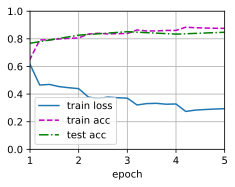

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr = lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


In [9]:
#Make predictions on sentiment
def predict_sentiment(net, vocab, sequence):
  sequence = torch.tensor(vocab[sequence.split()], device = d2l.try_gpu())
  label = torch.argmax(net(sequence.reshape(1,-1)), dim = -1)
  return 'positve' if label == 1 else 'negative'

samples = ['This movie is so horrible', 'This movie is fucking terrible', 'I am feeling well']

for sample in samples:
  print(f'label={predict_sentiment(net, vocab, sample)}, sentence={sample}') 


label=negative, sentence=This movie is so horrible
label=negative, sentence=This movie is fucking terrible


RuntimeError: ignored

# Exercises:

1. increase # epochs see if train and test accuracy increases
2. use larger glove, see if it increase accuracy
3. see if acc is increased if we uses spacy tokenizer to replace for tokenization

In [ ]:
# Use CNN for Sentiment Analysis
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [ ]:
def corr1d(X, K):
  w = K.shape[0]
  Y = torch.zeros((X.shape[0] - w + 1))
  for i in range(Y.shape[0]):
    Y[i] = (X[i : i + w] * K).sum()
  return Y

X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1,2])
output = corr1d(X, K)

print('output = ', output)
print('output shape = ', output.shape)

def corr1d_multi_in(X, K):
  return sum(corr1d(x, k) for x,k in zip(X, K))

X = torch.tensor([
    [0,1,2,3,4,5,6],
    [1,2,3,4,5,6,7],
    [2,3,4,5,6,7,8],
])

K = torch.tensor([
    [1,2],
    [3,4],
    [-1,-3],
])

output = corr1d_multi_in(X, K)

print('corr1d multi-in output ', output)
print('corr1d multi-in output shape ', output.shape)

output =  tensor([ 2.,  5.,  8., 11., 14., 17.])
output shape =  torch.Size([6])
corr1d multi-in output  tensor([ 2.,  8., 14., 20., 26., 32.])
corr1d multi-in output shape  torch.Size([6])


In [6]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(len(vocab), embed_size)
    #embedding layer that is NOT TO BE trained
    self.constant_embedding = nn.Embedding(len(vocab), embed_size)

    self.dropout = nn.Dropout(0.5)
    self.decoder = nn.Linear(sum(num_channels), 2)

    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()

    #create multiple 1d conv layers
    self.convs = nn.ModuleList()
    for c,k in zip(num_channels, kernel_sizes):
      # 2 * embed size because we concat embedding and constant_embedding output
      # each of them has embed size, so concat produces 2 * embed_size (check forward function)
      self.convs.append(nn.Conv1d(2 * embed_size, c, k))
  
  def forward(self, inputs):
    #concat 2 embedding vector at dim 2
    #output shape = (batch_size, # tokens, token vector dim)
    embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim = 2)
    #becuase of input format of conv1d layers
    #permute so that 2nd dim stores channels
    embeddings = embeddings.permute(0,2,1)
    #after max over time pooling, obtain tensor of shape (batch_size, # channels, 1)
    # remove the last dimension and concat along channels
    encoding = torch.cat([
        #squeeze at dim -1 make that last dimension a 1
        torch.squeeze(self.relu(self.pool(conv(embeddings))), dim = -1)
        for conv in self.convs
    ], dim = 1)
    #pass encoding to FC layers
    outputs = self.decoder(self.dropout(encoding))
    return outputs

#sample
#Num channel = to the dimension of Glove 
embed_size, kernel_sizes, num_channels = 100, [3,4,5], [100,100,100]

devices = d2l.try_all_gpus()

net = TextCNN(len(vocab), embed_size, kernel_sizes, num_channels)

def init_weights(module):
  if type(module) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(module.weight)

net.apply(init_weights)



TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [7]:
glove = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
#Load and lock constant_embedding weight
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False



loss 0.065, train acc 0.979, test acc 0.873
2424.6 examples/sec on [device(type='cuda', index=0)]


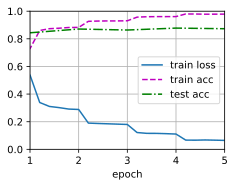

In [8]:
#Training 

lr, epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr = lr)
loss = nn.CrossEntropyLoss(reduction = 'none')

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)

In [12]:
samples = ['This movie is so horrible', 'This movie is fucking terrible', 'I am feeling well and I love my life']

for sample in samples:
  print(f'label={d2l.predict_sentiment(net, vocab, sample)}, sentence={sample}')

label=negative, sentence=This movie is so horrible
label=negative, sentence=This movie is fucking terrible
label=positive, sentence=I am feeling well and I love my life
